In [1]:
import os, glob, cv2, math, csv, tqdm, random, data_list_loader
import numpy as np
from keras import backend as k
from keras import applications, optimizers, losses, layers
from keras import layers ,losses
from keras.layers import Dropout, Input, concatenate, Dense, LeakyReLU, MaxPooling2D, UpSampling2D, GlobalAveragePooling2D, Flatten
from keras.models import Sequential, Model
from keras.preprocessing import image
from keras.layers.convolutional import Conv2D, Deconv2D, Conv2DTranspose
from keras.utils import generic_utils
from keras.backend import l2_normalize

from keras.optimizers import Adam
%matplotlib inline
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
def data_generator(image_path, lab_path, batch):
    
    dir_lists = sorted(os.listdir(image_path))
    total = []
    for i in dir_lists:
        paths = sorted(glob.glob(image_path+'/%s/*.png'%i))
        x = [[paths[i], paths[i+1]] for i in range(len(paths)-1)]
        for j in x:
            total.append(j)    

    dir_lists_lab = sorted(os.listdir(lab_path))
    total_lab = []
    for i in dir_lists_lab:
        paths_lab = sorted(glob.glob(lab_path+'/%s/*.png'%i))
        x = [[paths_lab[i]] for i in range(len(paths_lab))]
        for j in x:
            total_lab.append(j)
            
    idx = list(range(0,len(total)))
    random.shuffle(idx)
    while 1:
        idx_batch = random.sample(idx,batch)
        
        bat_img = []
        bat_lab = []
        
        for i in idx_batch:
            img = cv2.resize(np.concatenate((cv2.imread(total[i][0]),cv2.imread(total[i][1])),axis = 2),(512,384))/255.
            lab = cv2.resize(cv2.imread(total_lab[i][0]),(512,384))/255.
            bat_img.append(img)
            bat_lab.append(lab) 
        yield np.array(bat_img), [np.array([cv2.resize(i, (32, 24)) for i in bat_lab]),
                                  np.array([cv2.resize(i, (64, 48)) for i in bat_lab]), 
                                 np.array([cv2.resize(i, (128, 96)) for i in bat_lab]), 
                                 np.array([cv2.resize(i, (256, 192)) for i in bat_lab])]

In [3]:
def generator(inputs):
    conv1 = Conv2D(64, 7, padding = 'same', strides=(2, 2))(inputs)
    conv1 = LeakyReLU(alpha=0.1)(conv1)
    conv2 = Conv2D(128, 5,  padding = 'same', strides=(2, 2))(conv1)
    conv2 = LeakyReLU(alpha=0.1)(conv2)
    conv3 = Conv2D(256, 5,  padding = 'same', strides=(2, 2))(conv2)
    conv3 = LeakyReLU(alpha=0.1)(conv3)
    conv3_1 = Conv2D(256, 3, padding = 'same', strides=(1, 1))(conv3)
    conv3_1 = LeakyReLU(alpha=0.1)(conv3_1)
    conv4 = Conv2D(512, 3,  padding = 'same', strides=(2, 2))(conv3_1)
    conv4 = LeakyReLU(alpha=0.1)(conv4)
    conv4_1 = Conv2D(512, 3,  padding = 'same', strides=(1, 1))(conv4)
    conv4_1 = LeakyReLU(alpha=0.1)(conv4_1)
    conv5 = Conv2D(512, 3,  padding = 'same', strides=(2, 2))(conv4_1)
    conv5 = LeakyReLU(alpha=0.1)(conv5)
    conv5_1 = Conv2D(512, 3, padding = 'same', strides=(1, 1))(conv5)
    conv5_1 = LeakyReLU(alpha=0.1)(conv5_1)
    conv6 = Conv2D(1024, 3, padding = 'same', strides=(2, 2))(conv5_1)
    conv6 = LeakyReLU(alpha=0.1)(conv6)

    deconv5 = Conv2DTranspose(512, 5,  padding = 'same', use_bias=False, strides=(2, 2))(conv6)
    deconv5 = LeakyReLU(alpha=0.1)(deconv5)
    merge5 = concatenate([deconv5,conv5_1], axis = 3)
    aux1 = Conv2D(3, 5,  padding = 'same' , name = 'aux1')(UpSampling2D(size = (2,2))(merge5))
    aux1_1 = LeakyReLU(alpha=0.1)(aux1)
    
    deconv4 = Conv2DTranspose(256, 5, padding = 'same', use_bias=False, strides=(2, 2))(merge5)
    deconv4 = LeakyReLU(alpha=0.1)(deconv4)
    merge4 = concatenate([deconv4,conv4_1,aux1_1], axis = 3)
    aux2 = Conv2D(3, 5,  padding = 'same' , name = 'aux2')(UpSampling2D(size = (2,2))(merge4))
    aux2_1 = LeakyReLU(alpha=0.1)(aux2)
    
    deconv3 = Conv2DTranspose(128, 5, padding = 'same', use_bias=False, strides=(2, 2))(merge4)
    deconv3 = LeakyReLU(alpha=0.1)(deconv3)
    merge3 = concatenate([deconv3,conv3_1,aux2_1], axis = 3)
    aux3 = Conv2D(3, 5, padding = 'same' , name = 'aux3')(UpSampling2D(size = (2,2))(merge3))
    aux3_1 = LeakyReLU(alpha=0.1)(aux3)
    
    deconv2 = Conv2DTranspose(64, 5, padding = 'same', use_bias=False, strides=(2, 2))(merge3)
    deconv2 = LeakyReLU(alpha=0.1)(deconv2)
    merge2 = concatenate([deconv2,conv2,aux3_1], axis = 3)
    aux4 = Conv2D(3, 5, padding = 'same' , name = 'aux4')(UpSampling2D(size = (2,2))(merge2))
    aux4_1 = LeakyReLU(alpha=0.1)(aux4)
    output = Conv2D(3, 5, activation = 'sigmoid', padding = 'same')(aux4_1)
   
    model = Model(inputs = inputs, outputs = [aux1_1,aux2_1,aux3_1,output])
    return model

def discriminator(inputs):
    conv1 = Conv2D(64, 7, padding = 'same', strides=(2, 2))(inputs)
    conv1 = LeakyReLU(alpha=0.1)(conv1)
    conv2 = Conv2D(128, 5,  padding = 'same', strides=(2, 2))(conv1)
    conv2 = LeakyReLU(alpha=0.1)(conv2)
    conv3 = Conv2D(256, 5,  padding = 'same', strides=(2, 2))(conv2)
    conv3 = LeakyReLU(alpha=0.1)(conv3)
    conv3_1 = Conv2D(256, 3, padding = 'same', strides=(1, 1))(conv3)
    conv3_1 = LeakyReLU(alpha=0.1)(conv3_1)
    conv4 = Conv2D(512, 3,  padding = 'same', strides=(2, 2))(conv3_1)
    conv4 = LeakyReLU(alpha=0.1)(conv4)
    conv4_1 = Conv2D(512, 3,  padding = 'same', strides=(1, 1))(conv4)
    conv4_1 = LeakyReLU(alpha=0.1)(conv4_1)
    conv5 = Conv2D(512, 3,  padding = 'same', strides=(2, 2))(conv4_1)
    conv5 = LeakyReLU(alpha=0.1)(conv5)
    conv5_1 = Conv2D(512, 3, padding = 'same', strides=(1, 1))(conv5)
    conv5_1 = LeakyReLU(alpha=0.1)(conv5_1)
    conv6 = Conv2D(1024, 3, padding = 'same', strides=(2, 2))(conv5_1)
    conv6 = LeakyReLU(alpha=0.1)(conv6)
    
    fc1 = Flatten()(conv6)
    fc1_1 = Dense(512,activation= 'relu')(fc1)
    fc1_2 = Dense(128,activation= 'relu')(fc1_1)
    output = Dense(1, activation= 'sigmoid')(fc1_2)
    
    model = Model(inputs = inputs, outputs = output)
    return model

def gen_to_dis(x, generator, discriminator):
    gened_img = generator(x)
    outputs1 = discriminator(gened_img[-1])
    return gened_img, outputs1

In [4]:
gen_input = Input(shape=(384,512,6))
dis_input = Input(shape=(192,256,3))

model_gen = generator(gen_input)
model_dis = discriminator(dis_input)

all_output = gen_to_dis(gen_input, model_gen, model_dis)
model_all = Model(inputs = gen_input, outputs=[all_output[0][0], all_output[0][1],
                                               all_output[0][2], all_output[0][3], all_output[1]])

In [5]:
model_dis.compile(optimizer = Adam(lr = 0.0001), loss = 'binary_crossentropy')
model_dis.trainable = False

model_all.compile(optimizer = Adam(lr = 0.0001), loss = ['mse','mse','mse','mse','binary_crossentropy'],
                  loss_weights=[0.005,0.02,0.08,0.32,1])
model_dis.trainable = True

In [6]:
image_path = '../MPI/training/train'
lab_path = '../MPI/training/train_lab'

val_image_path = '../MPI/training/val'
val_lab_path = '../MPI/training/val_lab'

batch = 16
train = data_generator(image_path, lab_path, batch)

val = data_generator(val_image_path, val_lab_path, batch)


Epoch 1/5
1000/1000 [==============================] - 2s 2ms/step - dis loss: 0.6886 - gen loss: 0.75001


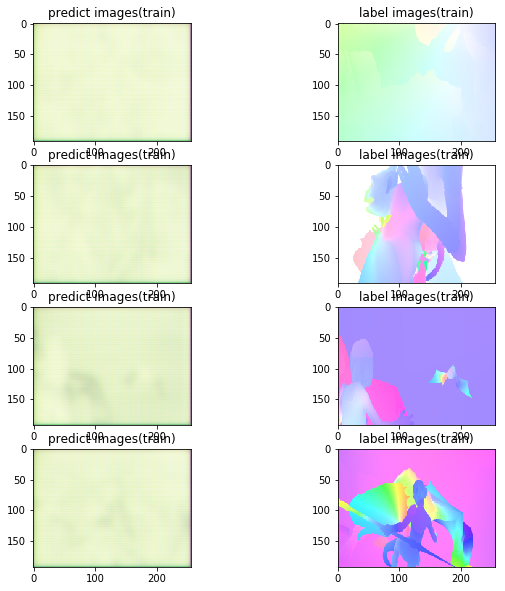

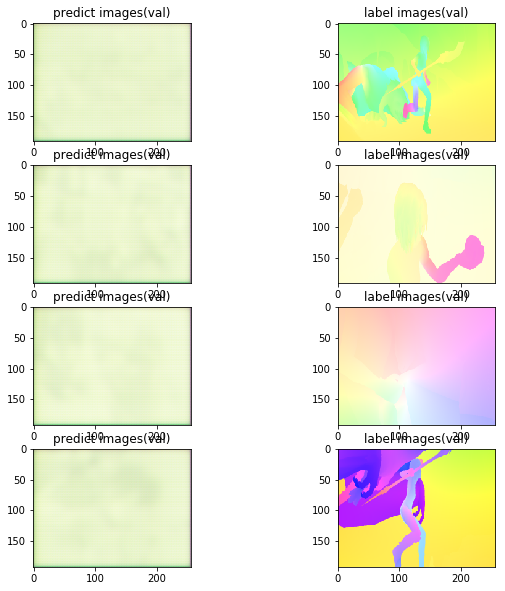


Epoch 2/5
 963/1000 [===========================>..] - ETA: 0s - dis loss: 4.8579 - gen loss: 9.4507923

In [ ]:
epochs = 5
num_iter = 1000
top_gen_loss = float('inf')
total_dis_loss = []
total_gen_loss = []
for epoch in range(epochs):
    print('\nEpoch {}/{}'.format(epoch+1, epochs))
    
    mean_dis_loss = 0
    mean_gen_loss = 0
    
    for i in range(num_iter):
        progbar = generic_utils.Progbar(num_iter)
        #print('Epoch {}/{}'.format(i, num_iter))
        gen_input_imgs, gen_labels = next(train)
        gened_img = model_gen.predict(gen_input_imgs)
                
        #dix_idx = np.random.choice(len(tr_y), batch_size)
        sample_dis_img = np.concatenate((gen_labels[-1], gened_img[-1]), axis=0)
        sample_dix_lab = np.zeros([2*batch, 1])
        sample_dix_lab[:batch] = 1. 
        
        dis_loss = model_dis.train_on_batch(sample_dis_img, sample_dix_lab)

        model_dis.trainable = False
        sample_dis_lab = np.ones([batch, 1])
        
        all_loss = model_all.train_on_batch(gen_input_imgs, [gen_labels[0],
                                                             gen_labels[1],
                                                             gen_labels[2],
                                                             gen_labels[3],
                                                             sample_dis_lab])

        model_dis.trainable = True
        
        mean_dis_loss += dis_loss
        mean_gen_loss += all_loss[0]
        
        total_dis_loss.append(dis_loss)
        total_gen_loss.append(all_loss[0])
                
        progbar.update(i+1, [('dis loss', mean_dis_loss/(i+1)), ('gen loss', mean_gen_loss/(i+1))])
        
    test_img, test_lab= next(train)
    test_p = model_gen.predict(test_img)
    
    plt.figure(figsize = (10,10))
    plt.subplot(421)
    plt.imshow(test_p[3][0])
    plt.title("predict images(train)")
    plt.subplot(422)
    plt.imshow(test_lab[3][0])
    plt.title("label images(train)")
    plt.subplot(423)
    plt.imshow(test_p[3][2])
    plt.title("predict images(train)")
    plt.subplot(424)
    plt.imshow(test_lab[3][2])
    plt.title("label images(train)")
    plt.subplot(425)
    plt.imshow(test_p[3][4])
    plt.title("predict images(train)")
    plt.subplot(426)
    plt.imshow(test_lab[3][4])
    plt.title("label images(train)")
    plt.subplot(427)
    plt.imshow(test_p[3][6])
    plt.title("predict images(train)")
    plt.subplot(428)
    plt.imshow(test_lab[3][6])
    plt.title("label images(train)")
    plt.show()

    
    test_img, test_lab= next(val)
    test_p = model_gen.predict(test_img)
    
    plt.figure(figsize = (10,10))
    plt.subplot(421)
    plt.imshow(test_p[3][0])
    plt.title("predict images(val)")
    plt.subplot(422)
    plt.imshow(test_lab[3][0])
    plt.title("label images(val)")
    plt.subplot(423)
    plt.imshow(test_p[3][2])
    plt.title("predict images(val)")
    plt.subplot(424)
    plt.imshow(test_lab[3][2])
    plt.title("label images(val)")
    plt.subplot(425)
    plt.imshow(test_p[3][4])
    plt.title("predict images(val)")
    plt.subplot(426)
    plt.imshow(test_lab[3][4])
    plt.title("label images(val)")
    plt.subplot(427)
    plt.imshow(test_p[3][6])
    plt.title("predict images(val)")
    plt.subplot(428)
    plt.imshow(test_lab[3][6])
    plt.title("label images(val)")
    plt.show()
    model_gen.save('save_gen_'+str(epoch)+'.h5')


In [ ]:
test_img, test_lab= next(val)
test_p = model_gen.predict(test_img)

plt.figure(figsize = (10,10))
plt.subplot(421)
plt.imshow(test_p[3][0])
plt.title("predict images(val)")
plt.subplot(422)
plt.imshow(test_lab[3][0])
plt.title("label images(val)")
plt.subplot(423)
plt.imshow(test_p[3][1])
plt.title("predict images(val)")
plt.subplot(424)
plt.imshow(test_lab[3][1])
plt.title("label images(val)")
plt.subplot(425)
plt.imshow(test_p[3][2])
plt.title("predict images(val)")
plt.subplot(426)
plt.imshow(test_lab[3][2])
plt.title("label images(val)")
plt.subplot(427)
plt.imshow(test_p[3][3])
plt.title("predict images(val)")
plt.subplot(428)
plt.imshow(test_lab[3][3])
plt.title("label images(val)")
plt.show()


In [ ]:
model_gen.save('save_gen_'str(epoch)+'.h5')